# M1. Actividad 1
# Diego Vitales Medellín A01611209

# Problemática

Se desea implementar agentes de limpieza dado un espacio y un porcentaje de suciedad de dicho espacio, para esto se desarrollaron agentes que se moveran a lo largo de dicho espacio para lograr su limpieza total. Pero, para medir su rendimiento, se establecerá un tiempo máximo para que los agentes terminen su trabajo, de esta manera se podra evaluar y tomar las medidas necesarias para mejorar nuestro modelo.

# Librerias

In [17]:
import time
import mesa
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Modelo y agentes

Para esta situación, se generaron dos agentes, los que realizaran la limpieza, y un agente "casilla", los cuales nos ayudaran a saber el estado de cada espacio en la cuadricula, ya sea si esta limpio o sucio. De esta manera, podemos facilitar la recolección y representación de la información, así como permitirnos un mayor control de las simulaciones

In [18]:
#Funcion para generar una matriz indicando el estado de cada casilla, y si se
#encuentra un agente en ella
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell

        for content in cell_content:
            #Si encontramos un agente en la casilla
            if isinstance(content, CleaningAgent):
                grid[x][y] = 2
            #Si es una casilla, mostramos su estado (limpia/sucia)
            else:
                grid[x][y] = content.state

    return grid

def get_clean_percentage(model):
    return model.clean_percentage

#Agente de limpieza
class CleaningAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.new_position = None #Variable para guardar el siguiente movimiento del agente
        self.moves = 0

    def step(self):
        #Obtenemos los vecinos del agente, incluyendo la casilla actual
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=True
        )

        for neighbor in neighbors:
            #Si los vecinos son una casilla de 'piso' y el agente se encuentra sobre ella
            if isinstance(neighbor, Tile) and neighbor.pos == self.pos:
                #Evaluamos el estado actual de esa casilla
                neighbor.next_state = neighbor.state
                
                #Limpiamos la casilla, de ser necesario y dejamos al agente en la misma casilla
                if neighbor.next_state == neighbor.DIRTY:
                    neighbor.next_state = neighbor.CLEAN
                    self.new_position = self.pos
                #Si no es necesario limpiar, movemos a nuestro agente
                else:
                    self.move()
                break

    #Funcion para asignar una nueva posicion aleatoria para el agente
    def move(self):
        neighborhood = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position = self.random.choice(neighborhood)
        self.new_position = new_position

    #Funcion de MESA para actualizar los datos despues del step
    def advance(self):
        #Obtenemos los vecinos
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=False,
            include_center=True
        )

        #Actualizamos el valor de la casilla que el agente limpio
        for neighbor in neighbors:
            if isinstance(neighbor, Tile) and neighbor.pos == self.pos:
                neighbor.state = neighbor.next_state
                break

        #Si se asigno una nueva posision diferente, agregamos a la variable de moviemientos
        if self.pos != self.new_position:
            self.moves += 1

        #Movemos el agente a la nueva posicion asignada
        self.model.grid.move_agent(self, self.new_position)

#Agente auxiliar para representar el estado de una casilla
class Tile(mesa.Agent):
    #Constantes para determinar el estado de la casilla
    DIRTY = 1
    CLEAN = 0

    #Definimos su posicion, estado, y estado siguiente
    def __init__(self, pos, model, state=CLEAN):
        super().__init__(pos, model)
        self.x, self.y = pos
        self.state = state
        self.next_state = None

#Modelo
class CleaningModel(mesa.Model):
    def __init__(self, num_agents, width, height, percentage):
        #Variables para incializar nuestro modelo MESA
        self.num_agents = num_agents
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.SimultaneousActivation(self)
        #Porcentajes de casillas sucias y limpias
        self.dirty_percentage = percentage
        self.clean_percentage = 1 - percentage

        #Asignamos casillas sucias de manera aleatoria en casillas vacias
        dirty_cells = int((width * height) * percentage)
        empty_cells = list(self.grid.empties)
        for cell in range(dirty_cells):
            empty_cell = self.random.choice(empty_cells)
            tile = Tile(empty_cell, self)
            tile.state = tile.DIRTY
            self.grid.place_agent(tile, empty_cell)
            self.schedule.add(tile)
            empty_cells.remove(empty_cell)

        #Asignamos el resto de casillas como limpias
        empty_cells = list(self.grid.empties)
        for cell in empty_cells:
            tile = Tile(cell, self)
            self.grid.place_agent(tile, cell)
            self.schedule.add(tile)

        #Agregamos los agentes a nuestro espacio
        for i in range(num_agents):
            cleaning_agent = CleaningAgent(i, self)
            self.grid.place_agent(cleaning_agent, (1, 1))
            self.schedule.add(cleaning_agent)

        #Definimos un datacollector para guardar la informacion de nuestro modelo
        self.datacollector = mesa.DataCollector(
            model_reporters={'Grid' : get_grid, 'CleanPercentage' : get_clean_percentage},
            agent_reporters={'Moves' : lambda a: getattr(a, 'moves', None)}
        )

    #Funcion para que nuestro modelo avance
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
    #Funcion para evaluar si se ha limpiado el espacio por completo
    def is_grid_clean(self):
        clean_cells = 0

        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            
            for content in cell_content:
                if isinstance(content, Tile) and content.state == content.CLEAN:
                    clean_cells += 1

        #Actualizamos el porcentaje de casillas limpias
        self.clean_percentage = clean_cells / (self.grid.width * self.grid.height)

        #Si se tiene un 100% de casillas limpias
        if self.clean_percentage == 1:
            return True
        
        return False

# Ejecución y graficación del modelo

En esta sección se envian las variables para inicializar nuestro modelo, así como parametros como porcentaje inicial de celdas sucias, así como un tiempo máximo de ejecución para evaluar el desempeño de nuestro modelo

In [19]:
#Inicializamos el modelo
model = CleaningModel(10, 100, 100, 0.5)
max_exec_time = 0.5

#Realizamos la simulacion mientras no se limpie por completo el espacio o se acabe el tiempo
init_time = time.time()
while not model.is_grid_clean() and time.time() - init_time < max_exec_time:
    model.step()
end_time = time.time()
execution_time = end_time - init_time

print("Max execution time: {}".format(max_exec_time))
print("Execution time: {}".format(execution_time))
if execution_time > max_exec_time:
    print("Time exceeded")
print("Clean percentage: {}".format(model.clean_percentage))

Max execution time: 0.5
Execution time: 0.5179569721221924
Time exceeded
Clean percentage: 0.5042


Obtenemos la información recopilada por nuestro modelo

In [20]:
#Obtenemos la informacion generada por el modelo
data = model.datacollector.get_model_vars_dataframe()
data.head()

,Grid,CleanPercentage
0,"[[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.5000
1,"[[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.5001
2,"[[2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.5001
3,"[[0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.5006
4,"[[0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.5007


Obtenemos la información sobre el avance de la limpieza por parte de la simulación actual

In [21]:
clean_percentages = data.loc[:, 'CleanPercentage']
clean_percentages

0     0.5000
1     0.5001
2     0.5001
3     0.5006
4     0.5007
5     0.5009
6     0.5011
7     0.5011
8     0.5014
9     0.5015
10    0.5017
11    0.5019
12    0.5020
13    0.5025
14    0.5028
15    0.5030
16    0.5032
17    0.5035
18    0.5035
19    0.5040
20    0.5040
Name: CleanPercentage, dtype: float64

Mostramos la información

<AxesSubplot: >

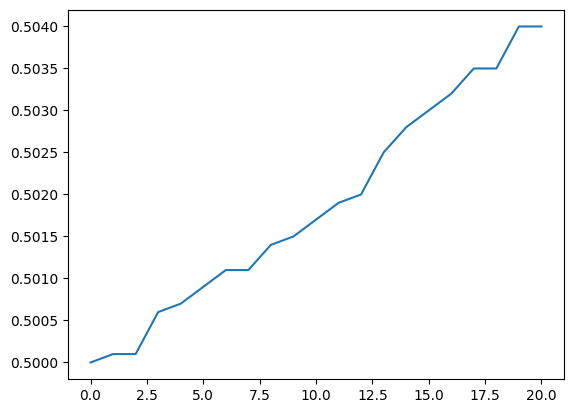

In [22]:
clean_percentages.plot()

Representamos la información en mapas de escalas de grises, los cuales utilizaremos para hacer una animación

In [23]:
%%capture

#Graficamos la informacion y generamos una animacion de su evolucion
figure, axis = plt.subplots(figsize=(7,7))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(data.iloc[0][0], cmap='Greys')

def animate(i):
    patch.set_data(data.iloc[i][0])

anim = animation.FuncAnimation(figure, animate, frames=len(data))

In [24]:
anim

# Reflexión

Después de realizar varias pruebas con este modelo, podemos decir que este tipo de implementación no es de lo más eficiente, ya que a pesar de tener casos exitosos, el movimiento aleatorio de los agentes afecta gravemente su desempeño, ya que lleva a recorrer muchas veces un mismo espacio que no requiere de acción alguna (limpiar, en este caso). Pero, si que quisiera aumentar este modelo sin modificación alguna en su lógica, sería necesario utilizar más agentes, lo que si lo llevamos a un mundo más real, no sería lo mejor, ya que se requerirían muchos más recursos para un problema relativamente sencillo, por lo que si realmente quisieramos llevar nuestro modelo a la vida real, deberíamos mejorar el algoritmo de limpieza de nuestros agentes para minimizar movimientos/acciones innecesarias, y debido a que este problema no es tan complejo, no sería tan necesaria la implementación de algorimtos o funcionalidades más complejas.